In [1]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm

In [2]:
sys.path.append('../')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.model import *
from script.loss import *

In [8]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/pseud_ashcolor_4label"
    train_label_path = f"{dataset_path}/labels/model1_iter_1/"
    new_label_path = f"{dataset_path}/labels/model1_iter_2/"
    train_model_path = ["/kaggle/working/notebook/experiment/v3/model1_iter1/model1_iter1/model1_iter1_fold0.pth",
                        "/kaggle/working/notebook/experiment/v3/model1_iter1/model1_iter1/model1_iter1_fold0.pth",
                        "/kaggle/working/notebook/experiment/v3/model1_iter1/model1_iter1/model1_iter1_fold1.pth",
                        "/kaggle/working/notebook/experiment/v3/model1_iter1/model1_iter1/model1_iter1_fold1.pth",
                        ]
    
    exp_name = os.getcwd().split('/')[-1]
    exp_description = "pseudo_ashcolor_4label_iter2"

    # ============== model cfg =============
    model_arch = 'Unet'
    backbone = 'timm-resnest200e'
    in_chans = 3
    target_size = 4
    fold = 4

    # ============== training cfg =============
    train_batch_size = 32
    valid_batch_size = train_batch_size

    epochs = 50
    if debug:
        epochs = 2

    lr = 1e-4
    loss = "DiceLoss"
    smooth = 300

    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        # A.ShiftScaleRotate(p=0.5, rotate_limit=(10, 10)),
        # A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=10, max_width=int(256 * 0.05), max_height=int(256 * 0.05),
                        mask_fill_value=0, p=0.5),
        A.RandomGridShuffle(),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)
pd.set_option('display.max_rows', 500)
pd.options.display.max_colwidth = 300

# Dataset

In [4]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
valid_df = pd.read_csv(f"{CFG.dataset_path}/validation_df.csv")
valid_df = valid_df.dropna()

train_df_true_label = train_df[~train_df["label_path"].isnull()]
train_df_pseud_label = train_df[train_df["label_path"].isnull()]

fill_path = CFG.train_label_path + train_df["record_id"].astype("str") + "_"+train_df["time"].astype("str")+".npy"
train_df_pseud_label["label_path"] = fill_path

train_df_true_label.loc[:, "fold"] = -1

kf = KFold(n_splits=CFG.fold, random_state=42, shuffle=True)
train_df_pseud_label.loc[:, "fold"] = None
for i, fold in enumerate(kf.split(train_df_pseud_label)):
    train_df_pseud_label["fold"].iloc[fold[1]] = i

train_df = pd.concat([train_df_pseud_label, train_df_true_label], axis=0).sort_values(by=["record_id", "time"]).reset_index(drop=True)

if CFG.debug:
    train_df=train_df[:200]
    valid_df=valid_df[:200]
train_df.shape, valid_df.shape
train_df.head(10)

,record_id,image_path,time,label_path,fold
0,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_0.npy,0,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model1_iter_1/195731008142151_0.npy,1
1,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_1.npy,1,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model1_iter_1/195731008142151_1.npy,3
2,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_2.npy,2,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model1_iter_1/195731008142151_2.npy,3
3,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_3.npy,3,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model1_iter_1/195731008142151_3.npy,0
4,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_4.npy,4,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/true/195731008142151_4.npy,-1
5,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_5.npy,5,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model1_iter_1/195731008142151_5.npy,3
6,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_6.npy,6,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model1_iter_1/195731008142151_6.npy,0
7,195731008142151,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/195731008142151_7.npy,7,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model1_iter_1/195731008142151_7.npy,3
8,1108741208571075,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/1108741208571075_0.npy,0,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model1_iter_1/1108741208571075_0.npy,3
9,1108741208571075,/kaggle/working/dataset_train/pseud_ashcolor_4label/images/1108741208571075_1.npy,1,/kaggle/working/dataset_train/pseud_ashcolor_4label/labels/model1_iter_1/1108741208571075_1.npy,1



len(dataset_train) = 164232
train_image_shape : torch.Size([3, 256, 256])
train_mask_shape  : torch.Size([4, 256, 256])
train_image_dtype : torch.float32
train_mask_dtype : torch.float32

len(dataset_valid) = 1856
valid_image_shape : torch.Size([3, 256, 256])
valid_mask_shape  : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_mask_dtype : torch.float32



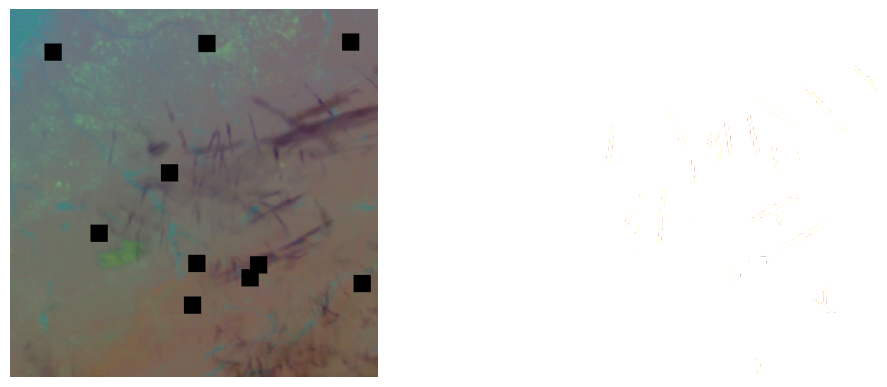

In [5]:
dataset_train = ContrailsDataset(train_df, CFG.train_aug_list, "pseudo_train")
dataset_valid = ContrailsDataset(valid_df, CFG.valid_aug_list, "pseudo_train")

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size , shuffle=True, num_workers = CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)

print(f"""
{len(dataset_train) = }
train_image_shape : {dataset_train[0][0].shape}
train_mask_shape  : {dataset_train[0][1].shape}
train_image_dtype : {dataset_train[0][0].dtype}
train_mask_dtype : {dataset_train[0][1].dtype}

{len(dataset_valid) = }
valid_image_shape : {dataset_valid[0][0].shape}
valid_mask_shape  : {dataset_valid[0][1].shape}
valid_image_dtype : {dataset_valid[0][0].dtype}
valid_mask_dtype : {dataset_valid[0][1].dtype}
""")

show_dataset(10, dataset_train)

# Training

In [9]:

if CFG.debug:
    print("!!!Debug mode!!!\n")

for fold in range(CFG.fold):
    print(f"fold : {fold}\n")
    dataset_train = ContrailsDataset(train_df[train_df["fold"] != fold], CFG.train_aug_list, "pseudo_train")
    dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size, shuffle=True, num_workers=CFG.num_workers)

    model = build_model(CFG.model_arch, CFG.backbone, CFG.in_chans, CFG.target_size)
    num_gpus = torch.cuda.device_count()
    device_ids = list(range(num_gpus))
    model = nn.DataParallel(model, device_ids=device_ids)

    scaler = amp.GradScaler()
    criterion = smp.losses.DiceLoss(mode="multilabel", smooth=CFG.smooth)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CFG.epochs, eta_min=1e-7)
    thresholds_to_test = [round(x * 0.01, 2) for x in range(1, 101, 2)]

    dice_score = 0
    slacknotify = SlackNotify(f"{CFG.exp_description} fold: {fold}")
    for epoch in range(CFG.epochs):
        model.train()

        pbar_train = enumerate(dataloader_train)
        pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")
        loss_train, loss_val = 0.0, 0.0
        for i, (images, masks) in pbar_train:
            images, masks = images.cuda(), masks.cuda()
            optimizer.zero_grad()
            with amp.autocast():
                preds = model(images)
                loss = criterion(preds, masks)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                loss_train += loss.detach().item()

            lr = f"LR : {scheduler.get_lr()[0]:.2E}"
            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, lr,
                                                                  f"Loss: {loss_train / (i + 1):.4f}"))

        scheduler.step()
        model.eval()

        cum_pred = []
        cum_true = []
        pbar_val = enumerate(dataloader_valid)
        pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        for i, (images, masks) in pbar_val:
            images, masks = images.cuda(), masks.cuda()
            with torch.no_grad():
                preds = model(images)[:, 2]
                loss_val += criterion(preds, masks).item()
                preds = torch.sigmoid(preds)
                cum_pred.append(preds.cpu().detach().numpy())
                cum_true.append(masks.cpu().detach().numpy())

            pbar_val.set_description(("%10s") % (f"Val Loss: {loss_val / (i+1):.4f}"))

        cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
        cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))

        dice_score_, thresh = calc_optim_thresh(cum_pred, cum_true, thresholds_to_test)

        if dice_score_ > dice_score:
            print(f"score : {dice_score_:.4f}\tthresh : {thresh}\tSAVED MODEL\n")
            slacknotify.send_reply(f"epoch : {epoch}\tscore : {dice_score_:.4f}\tBEST")
            epoch_best = epoch
            dice_score = dice_score_
            torch.save({'model': model.module.state_dict(), 'dice_score': dice_score, 'thresh': thresh,
                        "model_arch": CFG.model_arch, "backbone": CFG.backbone, "in_chans": CFG.in_chans, "target_size": CFG.target_size, },
                       f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold}.pth')
        else:
            print(f"score : {dice_score_:.4f}\tthresh : {thresh}\n")
            slacknotify.send_reply(f"epoch : {epoch}\tscore : {dice_score_:.4f}")

    slacknotify.send_reply(f" {CFG.exp_description} training finished\tbest score : {dice_score}", True)
    print()

fold : 1

model_arch:  Unet
backbone:  timm-resnest200e


Epoch 0/50  Mem : 15.4GB  LR : 1.00E-04  Loss: 0.3684: 100%|██████████| 4010/4010 [23:32<00:00,  2.84it/s]
Val Loss: 0.0306: 100%|██████████| 58/58 [00:13<00:00,  4.32it/s]


score : 0.6344	thresh : 0.29	SAVED MODEL



Epoch 1/50  Mem : 15.4GB  LR : 9.98E-05  Loss: 0.2434: 100%|██████████| 4010/4010 [23:14<00:00,  2.88it/s]
Val Loss: 0.0295: 100%|██████████| 58/58 [00:13<00:00,  4.26it/s]


score : 0.6527	thresh : 0.69	SAVED MODEL



Epoch 2/50  Mem : 15.4GB  LR : 9.93E-05  Loss: 0.2216: 100%|██████████| 4010/4010 [23:23<00:00,  2.86it/s]
Val Loss: 0.0294: 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]


score : 0.6528	thresh : 0.57	SAVED MODEL



Epoch 3/50  Mem : 15.4GB  LR : 9.86E-05  Loss: 0.2087: 100%|██████████| 4010/4010 [22:56<00:00,  2.91it/s]
Val Loss: 0.0281: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6543	thresh : 0.05	SAVED MODEL



Epoch 4/50  Mem : 15.4GB  LR : 9.78E-05  Loss: 0.1997: 100%|██████████| 4010/4010 [23:02<00:00,  2.90it/s]
Val Loss: 0.0282: 100%|██████████| 58/58 [00:13<00:00,  4.34it/s]


score : 0.6603	thresh : 0.27	SAVED MODEL



Epoch 5/50  Mem : 15.4GB  LR : 9.67E-05  Loss: 0.1929: 100%|██████████| 4010/4010 [23:08<00:00,  2.89it/s]
Val Loss: 0.0282: 100%|██████████| 58/58 [00:13<00:00,  4.31it/s]


score : 0.6616	thresh : 0.29	SAVED MODEL



Epoch 6/50  Mem : 15.4GB  LR : 9.54E-05  Loss: 0.1888: 100%|██████████| 4010/4010 [23:20<00:00,  2.86it/s]
Val Loss: 0.0288: 100%|██████████| 58/58 [00:13<00:00,  4.41it/s]


score : 0.6667	thresh : 0.97	SAVED MODEL



Epoch 7/50  Mem : 15.4GB  LR : 9.40E-05  Loss: 0.1816: 100%|██████████| 4010/4010 [23:17<00:00,  2.87it/s]
Val Loss: 0.0276: 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]


score : 0.6643	thresh : 0.05



Epoch 8/50  Mem : 15.4GB  LR : 9.24E-05  Loss: 0.1749: 100%|██████████| 4010/4010 [23:12<00:00,  2.88it/s]
Val Loss: 0.0280: 100%|██████████| 58/58 [00:13<00:00,  4.32it/s]


score : 0.6678	thresh : 0.83	SAVED MODEL



Epoch 9/50  Mem : 15.4GB  LR : 9.07E-05  Loss: 0.1712: 100%|██████████| 4010/4010 [23:21<00:00,  2.86it/s]
Val Loss: 0.0286: 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]


score : 0.6690	thresh : 0.93	SAVED MODEL



Epoch 10/50  Mem : 15.4GB  LR : 8.87E-05  Loss: 0.1672: 100%|██████████| 4010/4010 [23:07<00:00,  2.89it/s]
Val Loss: 0.0279: 100%|██████████| 58/58 [00:13<00:00,  4.34it/s]


score : 0.6689	thresh : 0.89



Epoch 11/50  Mem : 15.4GB  LR : 8.67E-05  Loss: 0.1641: 100%|██████████| 4010/4010 [23:11<00:00,  2.88it/s]
Val Loss: 0.0279: 100%|██████████| 58/58 [00:13<00:00,  4.28it/s]


score : 0.6694	thresh : 0.75	SAVED MODEL



Epoch 12/50  Mem : 15.4GB  LR : 8.44E-05  Loss: 0.1621: 100%|██████████| 4010/4010 [23:22<00:00,  2.86it/s]
Val Loss: 0.0270: 100%|██████████| 58/58 [00:13<00:00,  4.28it/s]


score : 0.6734	thresh : 0.07	SAVED MODEL



Epoch 13/50  Mem : 15.4GB  LR : 8.21E-05  Loss: 0.1593: 100%|██████████| 4010/4010 [23:06<00:00,  2.89it/s]
Val Loss: 0.0269: 100%|██████████| 58/58 [00:13<00:00,  4.34it/s]


score : 0.6715	thresh : 0.05



Epoch 14/50  Mem : 15.4GB  LR : 7.96E-05  Loss: 0.1578: 100%|██████████| 4010/4010 [23:16<00:00,  2.87it/s]
Val Loss: 0.0275: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6779	thresh : 0.97	SAVED MODEL



Epoch 15/50  Mem : 15.4GB  LR : 7.70E-05  Loss: 0.1563: 100%|██████████| 4010/4010 [23:03<00:00,  2.90it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6755	thresh : 0.01



Epoch 16/50  Mem : 15.4GB  LR : 7.43E-05  Loss: 0.1532: 100%|██████████| 4010/4010 [23:02<00:00,  2.90it/s]
Val Loss: 0.0265: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6772	thresh : 0.07



Epoch 17/50  Mem : 15.4GB  LR : 7.15E-05  Loss: 0.1516: 100%|██████████| 4010/4010 [22:59<00:00,  2.91it/s]
Val Loss: 0.0272: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6724	thresh : 0.23



Epoch 18/50  Mem : 15.4GB  LR : 6.86E-05  Loss: 0.1501: 100%|██████████| 4010/4010 [23:18<00:00,  2.87it/s]
Val Loss: 0.0331: 100%|██████████| 58/58 [00:13<00:00,  4.42it/s]


score : 0.6015	thresh : 0.01



Epoch 19/50  Mem : 15.4GB  LR : 6.57E-05  Loss: 0.1491: 100%|██████████| 4010/4010 [23:21<00:00,  2.86it/s]
Val Loss: 0.0276: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6747	thresh : 0.91



Epoch 20/50  Mem : 15.4GB  LR : 6.27E-05  Loss: 0.1476: 100%|██████████| 4010/4010 [23:16<00:00,  2.87it/s]
Val Loss: 0.0271: 100%|██████████| 58/58 [00:13<00:00,  4.28it/s]


score : 0.6749	thresh : 0.37



Epoch 21/50  Mem : 15.4GB  LR : 5.96E-05  Loss: 0.1461: 100%|██████████| 4010/4010 [23:25<00:00,  2.85it/s]
Val Loss: 0.0268: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6772	thresh : 0.17



Epoch 22/50  Mem : 15.4GB  LR : 5.65E-05  Loss: 0.1449: 100%|██████████| 4010/4010 [23:15<00:00,  2.87it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.37it/s]


score : 0.6731	thresh : 0.01



Epoch 23/50  Mem : 15.4GB  LR : 5.34E-05  Loss: 0.1435: 100%|██████████| 4010/4010 [23:24<00:00,  2.85it/s]
Val Loss: 0.0269: 100%|██████████| 58/58 [00:13<00:00,  4.24it/s]


score : 0.6789	thresh : 0.35	SAVED MODEL



Epoch 24/50  Mem : 15.4GB  LR : 5.02E-05  Loss: 0.1415: 100%|██████████| 4010/4010 [23:06<00:00,  2.89it/s]
Val Loss: 0.0263: 100%|██████████| 58/58 [00:13<00:00,  4.23it/s]


score : 0.6771	thresh : 0.01



Epoch 25/50  Mem : 15.4GB  LR : 4.71E-05  Loss: 0.1408: 100%|██████████| 4010/4010 [22:52<00:00,  2.92it/s]
Val Loss: 0.0267: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6779	thresh : 0.27



Epoch 26/50  Mem : 15.4GB  LR : 4.40E-05  Loss: 0.1399: 100%|██████████| 4010/4010 [22:54<00:00,  2.92it/s]
Val Loss: 0.0263: 100%|██████████| 58/58 [00:13<00:00,  4.34it/s]


score : 0.6793	thresh : 0.17	SAVED MODEL



Epoch 27/50  Mem : 15.4GB  LR : 4.09E-05  Loss: 0.1388: 100%|██████████| 4010/4010 [23:08<00:00,  2.89it/s]
Val Loss: 0.0265: 100%|██████████| 58/58 [00:13<00:00,  4.34it/s]


score : 0.6777	thresh : 0.01



Epoch 28/50  Mem : 15.4GB  LR : 3.78E-05  Loss: 0.1375: 100%|██████████| 4010/4010 [23:12<00:00,  2.88it/s]
Val Loss: 0.0269: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6779	thresh : 0.45



Epoch 29/50  Mem : 15.4GB  LR : 3.48E-05  Loss: 0.1367: 100%|██████████| 4010/4010 [23:22<00:00,  2.86it/s]
Val Loss: 0.0265: 100%|██████████| 58/58 [00:13<00:00,  4.34it/s]


score : 0.6800	thresh : 0.03	SAVED MODEL



Epoch 30/50  Mem : 15.4GB  LR : 3.18E-05  Loss: 0.1359: 100%|██████████| 4010/4010 [23:14<00:00,  2.88it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6789	thresh : 0.11



Epoch 31/50  Mem : 15.4GB  LR : 2.90E-05  Loss: 0.1347: 100%|██████████| 4010/4010 [23:21<00:00,  2.86it/s]
Val Loss: 0.0264: 100%|██████████| 58/58 [00:13<00:00,  4.33it/s]


score : 0.6772	thresh : 0.11



Epoch 32/50  Mem : 15.4GB  LR : 2.62E-05  Loss: 0.1335: 100%|██████████| 4010/4010 [23:09<00:00,  2.89it/s]
Val Loss: 0.0268: 100%|██████████| 58/58 [00:13<00:00,  4.32it/s]


score : 0.6785	thresh : 0.55



Epoch 33/50  Mem : 15.4GB  LR : 2.35E-05  Loss: 0.1330: 100%|██████████| 4010/4010 [23:14<00:00,  2.88it/s]
Val Loss: 0.0267: 100%|██████████| 58/58 [00:13<00:00,  4.31it/s]


score : 0.6788	thresh : 0.07



Epoch 34/50  Mem : 15.4GB  LR : 2.09E-05  Loss: 0.1322: 100%|██████████| 4010/4010 [23:17<00:00,  2.87it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6772	thresh : 0.03



Epoch 35/50  Mem : 15.4GB  LR : 1.84E-05  Loss: 0.1311: 100%|██████████| 4010/4010 [23:07<00:00,  2.89it/s]
Val Loss: 0.0263: 100%|██████████| 58/58 [00:13<00:00,  4.39it/s]


score : 0.6791	thresh : 0.11



Epoch 36/50  Mem : 15.4GB  LR : 1.60E-05  Loss: 0.1305: 100%|██████████| 4010/4010 [23:04<00:00,  2.90it/s]
Val Loss: 0.0264: 100%|██████████| 58/58 [00:13<00:00,  4.34it/s]


score : 0.6798	thresh : 0.09



Epoch 37/50  Mem : 15.4GB  LR : 1.38E-05  Loss: 0.1299: 100%|██████████| 4010/4010 [23:09<00:00,  2.88it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6804	thresh : 0.49	SAVED MODEL



Epoch 38/50  Mem : 15.4GB  LR : 1.17E-05  Loss: 0.1300: 100%|██████████| 4010/4010 [23:10<00:00,  2.88it/s]
Val Loss: 0.0265: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6786	thresh : 0.01



Epoch 39/50  Mem : 15.4GB  LR : 9.81E-06  Loss: 0.1294: 100%|██████████| 4010/4010 [23:16<00:00,  2.87it/s]
Val Loss: 0.0264: 100%|██████████| 58/58 [00:14<00:00,  3.99it/s]


score : 0.6803	thresh : 0.05



Epoch 40/50  Mem : 15.4GB  LR : 8.04E-06  Loss: 0.1285: 100%|██████████| 4010/4010 [23:12<00:00,  2.88it/s]
Val Loss: 0.0264: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6796	thresh : 0.33



Epoch 41/50  Mem : 15.4GB  LR : 6.44E-06  Loss: 0.1278: 100%|██████████| 4010/4010 [23:16<00:00,  2.87it/s]
Val Loss: 0.0264: 100%|██████████| 58/58 [00:13<00:00,  4.34it/s]


score : 0.6792	thresh : 0.01



Epoch 42/50  Mem : 15.4GB  LR : 5.01E-06  Loss: 0.1279: 100%|██████████| 4010/4010 [23:11<00:00,  2.88it/s]
Val Loss: 0.0264: 100%|██████████| 58/58 [00:13<00:00,  4.32it/s]


score : 0.6784	thresh : 0.13



Epoch 43/50  Mem : 15.4GB  LR : 3.76E-06  Loss: 0.1272: 100%|██████████| 4010/4010 [23:09<00:00,  2.89it/s]
Val Loss: 0.0264: 100%|██████████| 58/58 [00:13<00:00,  4.34it/s]


score : 0.6783	thresh : 0.01



Epoch 44/50  Mem : 15.4GB  LR : 2.69E-06  Loss: 0.1267: 100%|██████████| 4010/4010 [23:02<00:00,  2.90it/s]
Val Loss: 0.0263: 100%|██████████| 58/58 [00:13<00:00,  4.31it/s]


score : 0.6804	thresh : 0.21	SAVED MODEL



Epoch 45/50  Mem : 15.4GB  LR : 1.80E-06  Loss: 0.1269: 100%|██████████| 4010/4010 [23:07<00:00,  2.89it/s]
Val Loss: 0.0264: 100%|██████████| 58/58 [00:13<00:00,  4.32it/s]


score : 0.6797	thresh : 0.05



Epoch 46/50  Mem : 15.4GB  LR : 1.11E-06  Loss: 0.1271: 100%|██████████| 4010/4010 [23:20<00:00,  2.86it/s]
Val Loss: 0.0263: 100%|██████████| 58/58 [00:13<00:00,  4.28it/s]


score : 0.6795	thresh : 0.21



Epoch 47/50  Mem : 15.4GB  LR : 5.99E-07  Loss: 0.1266: 100%|██████████| 4010/4010 [23:16<00:00,  2.87it/s]
Val Loss: 0.0265: 100%|██████████| 58/58 [00:13<00:00,  4.31it/s]


score : 0.6803	thresh : 0.15



Epoch 48/50  Mem : 15.4GB  LR : 2.75E-07  Loss: 0.1270: 100%|██████████| 4010/4010 [23:18<00:00,  2.87it/s]
Val Loss: 0.0264: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6801	thresh : 0.11



Epoch 49/50  Mem : 15.4GB  LR : 1.25E-07  Loss: 0.1266: 100%|██████████| 4010/4010 [23:16<00:00,  2.87it/s]
Val Loss: 0.0264: 100%|██████████| 58/58 [00:13<00:00,  4.32it/s]


score : 0.6798	thresh : 0.05


fold : 2

model_arch:  Unet
backbone:  timm-resnest200e


Epoch 0/50  Mem : 15.4GB  LR : 1.00E-04  Loss: 0.3792: 100%|██████████| 4010/4010 [23:12<00:00,  2.88it/s]
Val Loss: 0.0304: 100%|██████████| 58/58 [00:13<00:00,  4.32it/s]


score : 0.6352	thresh : 0.53	SAVED MODEL



Epoch 1/50  Mem : 15.4GB  LR : 9.98E-05  Loss: 0.2460: 100%|██████████| 4010/4010 [23:17<00:00,  2.87it/s]
Val Loss: 0.0303: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6485	thresh : 0.79	SAVED MODEL



Epoch 2/50  Mem : 15.4GB  LR : 9.93E-05  Loss: 0.2254: 100%|██████████| 4010/4010 [23:16<00:00,  2.87it/s]
Val Loss: 0.0288: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6498	thresh : 0.05	SAVED MODEL



Epoch 3/50  Mem : 15.4GB  LR : 9.86E-05  Loss: 0.2110: 100%|██████████| 4010/4010 [23:15<00:00,  2.87it/s]
Val Loss: 0.0288: 100%|██████████| 58/58 [00:13<00:00,  4.32it/s]


score : 0.6564	thresh : 0.65	SAVED MODEL



Epoch 4/50  Mem : 15.4GB  LR : 9.78E-05  Loss: 0.2019: 100%|██████████| 4010/4010 [23:14<00:00,  2.88it/s]
Val Loss: 0.0277: 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]


score : 0.6604	thresh : 0.23	SAVED MODEL



Epoch 5/50  Mem : 15.4GB  LR : 9.67E-05  Loss: 0.1957: 100%|██████████| 4010/4010 [23:19<00:00,  2.86it/s]
Val Loss: 0.0301: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6536	thresh : 0.93



Epoch 6/50  Mem : 15.4GB  LR : 9.54E-05  Loss: 0.1891: 100%|██████████| 4010/4010 [23:16<00:00,  2.87it/s]
Val Loss: 0.0288: 100%|██████████| 58/58 [00:13<00:00,  4.31it/s]


score : 0.6631	thresh : 0.89	SAVED MODEL



Epoch 7/50  Mem : 15.4GB  LR : 9.40E-05  Loss: 0.1821: 100%|██████████| 4010/4010 [23:23<00:00,  2.86it/s]
Val Loss: 0.0281: 100%|██████████| 58/58 [00:14<00:00,  3.92it/s]


score : 0.6630	thresh : 0.33



Epoch 8/50  Mem : 15.4GB  LR : 9.24E-05  Loss: 0.1758: 100%|██████████| 4010/4010 [23:40<00:00,  2.82it/s]
Val Loss: 0.0274: 100%|██████████| 58/58 [00:13<00:00,  4.33it/s]


score : 0.6684	thresh : 0.17	SAVED MODEL



Epoch 9/50  Mem : 15.4GB  LR : 9.07E-05  Loss: 0.1726: 100%|██████████| 4010/4010 [23:34<00:00,  2.84it/s]
Val Loss: 0.0270: 100%|██████████| 58/58 [00:13<00:00,  4.28it/s]


score : 0.6681	thresh : 0.03



Epoch 10/50  Mem : 15.4GB  LR : 8.87E-05  Loss: 0.1690: 100%|██████████| 4010/4010 [23:21<00:00,  2.86it/s]
Val Loss: 0.0278: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6683	thresh : 0.43



Epoch 11/50  Mem : 15.4GB  LR : 8.67E-05  Loss: 0.1659: 100%|██████████| 4010/4010 [23:27<00:00,  2.85it/s]
Val Loss: 0.0276: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6688	thresh : 0.39	SAVED MODEL



Epoch 12/50  Mem : 15.4GB  LR : 8.44E-05  Loss: 0.1636: 100%|██████████| 4010/4010 [23:19<00:00,  2.87it/s]
Val Loss: 0.0274: 100%|██████████| 58/58 [00:13<00:00,  4.34it/s]


score : 0.6696	thresh : 0.23	SAVED MODEL



Epoch 13/50  Mem : 15.4GB  LR : 8.21E-05  Loss: 0.1610: 100%|██████████| 4010/4010 [23:07<00:00,  2.89it/s]
Val Loss: 0.0268: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6731	thresh : 0.13	SAVED MODEL



Epoch 14/50  Mem : 15.4GB  LR : 7.96E-05  Loss: 0.1590: 100%|██████████| 4010/4010 [23:15<00:00,  2.87it/s]
Val Loss: 0.0269: 100%|██████████| 58/58 [00:13<00:00,  4.39it/s]


score : 0.6720	thresh : 0.15



Epoch 15/50  Mem : 15.4GB  LR : 7.70E-05  Loss: 0.1568: 100%|██████████| 4010/4010 [23:23<00:00,  2.86it/s]
Val Loss: 0.0277: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6703	thresh : 0.91



Epoch 16/50  Mem : 15.4GB  LR : 7.43E-05  Loss: 0.1553: 100%|██████████| 4010/4010 [23:18<00:00,  2.87it/s]
Val Loss: 0.0272: 100%|██████████| 58/58 [00:13<00:00,  4.33it/s]


score : 0.6743	thresh : 0.71	SAVED MODEL



Epoch 17/50  Mem : 15.4GB  LR : 7.15E-05  Loss: 0.1537: 100%|██████████| 4010/4010 [23:22<00:00,  2.86it/s]
Val Loss: 0.0270: 100%|██████████| 58/58 [00:13<00:00,  4.32it/s]


score : 0.6753	thresh : 0.35	SAVED MODEL



Epoch 18/50  Mem : 15.4GB  LR : 6.86E-05  Loss: 0.1518: 100%|██████████| 4010/4010 [23:17<00:00,  2.87it/s]
Val Loss: 0.0272: 100%|██████████| 58/58 [00:13<00:00,  4.39it/s]


score : 0.6766	thresh : 0.73	SAVED MODEL



Epoch 19/50  Mem : 15.4GB  LR : 6.57E-05  Loss: 0.1506: 100%|██████████| 4010/4010 [23:31<00:00,  2.84it/s]
Val Loss: 0.0270: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6761	thresh : 0.73



Epoch 20/50  Mem : 15.4GB  LR : 6.27E-05  Loss: 0.1487: 100%|██████████| 4010/4010 [23:21<00:00,  2.86it/s]
Val Loss: 0.0269: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6765	thresh : 0.09



Epoch 21/50  Mem : 15.4GB  LR : 5.96E-05  Loss: 0.1474: 100%|██████████| 4010/4010 [23:10<00:00,  2.88it/s]
Val Loss: 0.0270: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6771	thresh : 0.69	SAVED MODEL



Epoch 22/50  Mem : 15.4GB  LR : 5.65E-05  Loss: 0.1456: 100%|██████████| 4010/4010 [23:16<00:00,  2.87it/s]
Val Loss: 0.0273: 100%|██████████| 58/58 [00:13<00:00,  4.32it/s]


score : 0.6755	thresh : 0.85



Epoch 23/50  Mem : 15.4GB  LR : 5.34E-05  Loss: 0.1445: 100%|██████████| 4010/4010 [23:08<00:00,  2.89it/s]
Val Loss: 0.0269: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6784	thresh : 0.11	SAVED MODEL



Epoch 24/50  Mem : 15.4GB  LR : 5.02E-05  Loss: 0.1432: 100%|██████████| 4010/4010 [23:14<00:00,  2.87it/s]
Val Loss: 0.0267: 100%|██████████| 58/58 [00:13<00:00,  4.38it/s]


score : 0.6776	thresh : 0.07



Epoch 25/50  Mem : 15.4GB  LR : 4.71E-05  Loss: 0.1424: 100%|██████████| 4010/4010 [23:23<00:00,  2.86it/s]
Val Loss: 0.0264: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6764	thresh : 0.01



Epoch 26/50  Mem : 15.4GB  LR : 4.40E-05  Loss: 0.1413: 100%|██████████| 4010/4010 [23:19<00:00,  2.87it/s]
Val Loss: 0.0271: 100%|██████████| 58/58 [00:13<00:00,  4.40it/s]


score : 0.6759	thresh : 0.25



Epoch 27/50  Mem : 15.4GB  LR : 4.09E-05  Loss: 0.1392: 100%|██████████| 4010/4010 [23:05<00:00,  2.89it/s]
Val Loss: 0.0265: 100%|██████████| 58/58 [00:13<00:00,  4.32it/s]


score : 0.6758	thresh : 0.09



Epoch 28/50  Mem : 15.4GB  LR : 3.78E-05  Loss: 0.1389: 100%|██████████| 4010/4010 [23:23<00:00,  2.86it/s]
Val Loss: 0.0269: 100%|██████████| 58/58 [00:13<00:00,  4.39it/s]


score : 0.6774	thresh : 0.35



Epoch 29/50  Mem : 15.4GB  LR : 3.48E-05  Loss: 0.1375: 100%|██████████| 4010/4010 [23:24<00:00,  2.85it/s]
Val Loss: 0.0268: 100%|██████████| 58/58 [00:13<00:00,  4.39it/s]


score : 0.6759	thresh : 0.17



Epoch 30/50  Mem : 15.4GB  LR : 3.18E-05  Loss: 0.1365: 100%|██████████| 4010/4010 [23:25<00:00,  2.85it/s]
Val Loss: 0.0267: 100%|██████████| 58/58 [00:13<00:00,  4.34it/s]


score : 0.6791	thresh : 0.49	SAVED MODEL



Epoch 31/50  Mem : 15.4GB  LR : 2.90E-05  Loss: 0.1359: 100%|██████████| 4010/4010 [23:28<00:00,  2.85it/s]
Val Loss: 0.0267: 100%|██████████| 58/58 [00:13<00:00,  4.37it/s]


score : 0.6765	thresh : 0.29



Epoch 32/50  Mem : 15.4GB  LR : 2.62E-05  Loss: 0.1354: 100%|██████████| 4010/4010 [23:31<00:00,  2.84it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.37it/s]


score : 0.6767	thresh : 0.37



Epoch 33/50  Mem : 15.4GB  LR : 2.35E-05  Loss: 0.1346: 100%|██████████| 4010/4010 [23:23<00:00,  2.86it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.38it/s]


score : 0.6781	thresh : 0.17



Epoch 34/50  Mem : 15.4GB  LR : 2.09E-05  Loss: 0.1334: 100%|██████████| 4010/4010 [23:10<00:00,  2.88it/s]
Val Loss: 0.0267: 100%|██████████| 58/58 [00:13<00:00,  4.33it/s]


score : 0.6766	thresh : 0.21



Epoch 35/50  Mem : 15.4GB  LR : 1.84E-05  Loss: 0.1322: 100%|██████████| 4010/4010 [23:26<00:00,  2.85it/s]
Val Loss: 0.0267: 100%|██████████| 58/58 [00:13<00:00,  4.33it/s]


score : 0.6778	thresh : 0.53



Epoch 36/50  Mem : 15.4GB  LR : 1.60E-05  Loss: 0.1318: 100%|██████████| 4010/4010 [23:23<00:00,  2.86it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.37it/s]


score : 0.6785	thresh : 0.63



Epoch 37/50  Mem : 15.4GB  LR : 1.38E-05  Loss: 0.1311: 100%|██████████| 4010/4010 [23:21<00:00,  2.86it/s]
Val Loss: 0.0265: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6782	thresh : 0.31



Epoch 38/50  Mem : 15.4GB  LR : 1.17E-05  Loss: 0.1301: 100%|██████████| 4010/4010 [23:22<00:00,  2.86it/s]
Val Loss: 0.0267: 100%|██████████| 58/58 [00:13<00:00,  4.34it/s]


score : 0.6777	thresh : 0.27



Epoch 39/50  Mem : 15.4GB  LR : 9.81E-06  Loss: 0.1305: 100%|██████████| 4010/4010 [23:18<00:00,  2.87it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.37it/s]


score : 0.6778	thresh : 0.09



Epoch 40/50  Mem : 15.4GB  LR : 8.04E-06  Loss: 0.1299: 100%|██████████| 4010/4010 [23:17<00:00,  2.87it/s]
Val Loss: 0.0268: 100%|██████████| 58/58 [00:13<00:00,  4.34it/s]


score : 0.6784	thresh : 0.23



Epoch 41/50  Mem : 15.4GB  LR : 6.44E-06  Loss: 0.1294: 100%|██████████| 4010/4010 [23:03<00:00,  2.90it/s]
Val Loss: 0.0265: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6782	thresh : 0.13



Epoch 42/50  Mem : 15.4GB  LR : 5.01E-06  Loss: 0.1296: 100%|██████████| 4010/4010 [23:17<00:00,  2.87it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.34it/s]


score : 0.6783	thresh : 0.13



Epoch 43/50  Mem : 15.4GB  LR : 3.76E-06  Loss: 0.1286: 100%|██████████| 4010/4010 [23:16<00:00,  2.87it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.36it/s]


score : 0.6781	thresh : 0.27



Epoch 44/50  Mem : 15.4GB  LR : 2.69E-06  Loss: 0.1282: 100%|██████████| 4010/4010 [23:20<00:00,  2.86it/s]
Val Loss: 0.0265: 100%|██████████| 58/58 [00:13<00:00,  4.35it/s]


score : 0.6780	thresh : 0.05



Epoch 45/50  Mem : 15.4GB  LR : 1.80E-06  Loss: 0.1283: 100%|██████████| 4010/4010 [23:27<00:00,  2.85it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]


score : 0.6789	thresh : 0.05



Epoch 46/50  Mem : 15.4GB  LR : 1.11E-06  Loss: 0.1280: 100%|██████████| 4010/4010 [23:29<00:00,  2.84it/s]
Val Loss: 0.0265: 100%|██████████| 58/58 [00:13<00:00,  4.30it/s]


score : 0.6786	thresh : 0.17



Epoch 47/50  Mem : 15.4GB  LR : 5.99E-07  Loss: 0.1274: 100%|██████████| 4010/4010 [23:25<00:00,  2.85it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.37it/s]


score : 0.6787	thresh : 0.17



Epoch 48/50  Mem : 15.4GB  LR : 2.75E-07  Loss: 0.1279: 100%|██████████| 4010/4010 [23:09<00:00,  2.89it/s]
Val Loss: 0.0266: 100%|██████████| 58/58 [00:13<00:00,  4.34it/s]


score : 0.6785	thresh : 0.07



Epoch 49/50  Mem : 15.4GB  LR : 1.25E-07  Loss: 0.1258:  47%|████▋     | 1866/4010 [10:57<12:35,  2.84it/s]


KeyboardInterrupt: 

# Pseudo Labelling

In [8]:
def pseudo_inference(dataloader_label, model, thresh, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for i, (images, record_ids, times) in tqdm(enumerate(dataloader_label), total=len(dataloader_label)):
        images = images.cuda()
        with torch.no_grad():
            preds = model(images)
        preds = torch.sigmoid(preds).cpu().detach().numpy()
        preds_thresh = np.where(preds > thresh, 1, 0)

        for num in range(images.shape[0]):
            pred = preds_thresh[num, :, :, :].transpose(1, 2, 0)
            record_id = int(record_ids[num])
            time = int(times[num])
            save_path = f"{save_dir}/{record_id}_{time}.npy"
            np.save(save_path, pred)

In [9]:
for fold in range(CFG.fold):
    label_df = train_df[train_df["fold"] == fold]

    dataset_label = ContrailsDataset(label_df, CFG.valid_aug_list, "pseudo_labeling")
    dataloader_label = DataLoader(dataset_label, batch_size=CFG.valid_batch_size, num_workers=CFG.num_workers)

    model_path = sorted(glob(f"./{CFG.exp_name}/*.pth"))[fold]
    model, dice_score, thresh = load_model(model_path)
    model.eval()
    print(f"{dice_score = :.4f}")
    print(f"{thresh = }")

    pseudo_inference(dataloader_label, model, thresh, CFG.new_label_path)

model_arch:  Unet
backbone:  timm-resnest200e
dice_score = 0.6702
thresh = 0.11


100%|██████████| 2246/2246 [13:27<00:00,  2.78it/s]


model_arch:  Unet
backbone:  timm-resnest200e
dice_score = 0.6693
thresh = 0.99


100%|██████████| 2246/2246 [13:30<00:00,  2.77it/s]


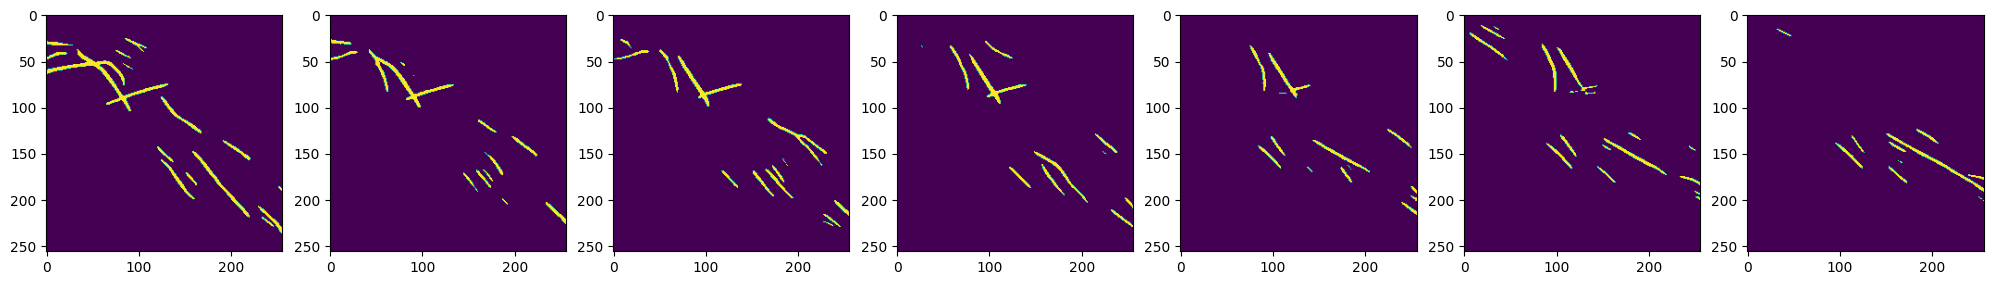

In [18]:
no = 16
id = os.listdir(CFG.new_label_path)[no*7].split("_")[0]
fig, ax = plt.subplots(1, 7, figsize=(25, 10))
for i, time in enumerate([0, 1, 2, 3, 5, 6, 7]):
    npy = np.load(f"{CFG.new_label_path}/{id}_{time}.npy")
    ax[i].imshow(npy)

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = "/kaggle/working/notebook/experiment/v3/iter03/iter03/iter03_fold0.pth"
model, dice_score, thresh = load_model(model_path)
model.eval();
print(f"{dice_score = :.4f}, {thresh = }")

from sklearn.metrics import confusion_matrix
cum_pred = []
cum_true = []
for i, (images, masks) in enumerate(tqdm(dataloader_valid, total=len(dataloader_valid))):
    images, masks = images.cuda(), masks.cuda()
    with torch.no_grad():
        preds = model(images)
        preds = torch.sigmoid(preds)
        cum_pred.append(preds.cpu().detach().numpy())
        cum_true.append(masks.cpu().detach().numpy())
cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))
dice = calc_dice_score(cum_pred, cum_true, thresh)
# thresh=thresh+0.01
cum_pred_ = np.where(cum_pred > thresh, 1, 0)
print(f"{dice = :.4f}")
cm = confusion_matrix(np.array(cum_true), np.array(cum_pred_))
cm

model_arch:  Unet
backbone:  timm-resnest200e
dice_score = 0.6695, thresh = 0.83


100%|██████████| 58/58 [00:07<00:00,  7.87it/s]


dice = 0.6695


array([[121344904,     69466],
       [    74565,    145881]])

In [ ]:
cm